# Décomposition : saisonnalité

**Objectif**
- modéliser la saisonnalité _(pour repérer les mouvements saisonniers de notre série)_
- soustraire la saisonnalité
- déterminer les ordres de différenciation, d'autorégressif, de moyenne mobile

**Outils pour la saisonnalité**
- seasonal plot _(sans et avec superposition de séries)_
- périodogramme

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.functions.seasonality import SeasonalPlotter, check_stationarity_and_difference
from src.utils import init_notebook

In [ ]:
init_notebook()

## Import des données traitées de la tendance

In [ ]:
data_folder = "data/processed_data/detrend_data/LinearMADetrend/window-100"
stock_name = "AAPL"

In [ ]:
df_detrend = pd.read_csv(
    f"{data_folder}/{stock_name}.csv", parse_dates=["Date"], index_col="Date"
)
print(f"{df_detrend.shape = }")

df_detrend.shape = (756, 6)


In [ ]:
df_detrend.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,-2.636750,-1.646748,-2.801751,-1.879250,-3.465916,148158800
2019-01-03,-5.465638,-5.030637,-5.960637,-5.913137,-7.341764,365248800
2019-01-04,-5.434760,-4.429759,-5.617259,-4.502261,-5.991877,234428400
2019-01-07,-4.487831,-4.455330,-5.187832,-4.680332,-6.166622,219111200
2019-01-08,-4.372408,-3.807405,-4.632406,-4.074907,-5.589533,164101200


In [ ]:
# Take close price only
close_detrend = df_detrend["Close"]

## Graphe de saisonnalité en utilisant l'API statsmodels

### Saisonnalité mensuelle

Pour chaque mois, on fait la moyenne des prix de clôture.  
Puis on affiche le graphe de saisonnalité.  
La barre rouge représente, pour le mois de janvier par exemple, la moyenne sur tous les mois de janvier (01-19, 01-20, 01-21 etc.)  

In [ ]:
close_monthly_resample = close_detrend.resample("M").mean()
close_monthly_resample.head()

Date
2019-01-31   -3.792133
2019-02-28   -1.279019
2019-03-31    0.514090
2019-04-30    3.201218
2019-05-31   -0.825486
Freq: M, Name: Close, dtype: float64

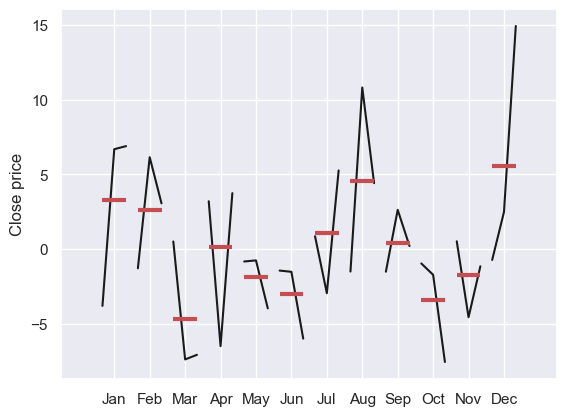

In [ ]:
fig = sm.graphics.tsa.month_plot(close_monthly_resample, ylabel="Close price")

### Saisonnalité hebdomadaire

In [ ]:
# Resample on week frequency
close_weekly_resample = close_detrend.resample("W").mean()
close_weekly_resample

Date
2019-01-06    -4.098216
2019-01-13    -3.975125
2019-01-20    -3.798467
2019-01-27    -4.138694
2019-02-03    -2.734122
                ...    
2021-12-05     6.961971
2021-12-12    16.062935
2021-12-19    16.276648
2021-12-26    14.106925
2022-01-02    18.462308
Freq: W-SUN, Name: Close, Length: 157, dtype: float64

In [ ]:
# Create groupby object needed by seasonal_plot function of statsmodels
groupby_week_object = close_weekly_resample.groupby(lambda resample: resample.week)

In [ ]:
# Define xticklabels, index of week
xticklabels = [f"{i}" for i in range(1, 54)]

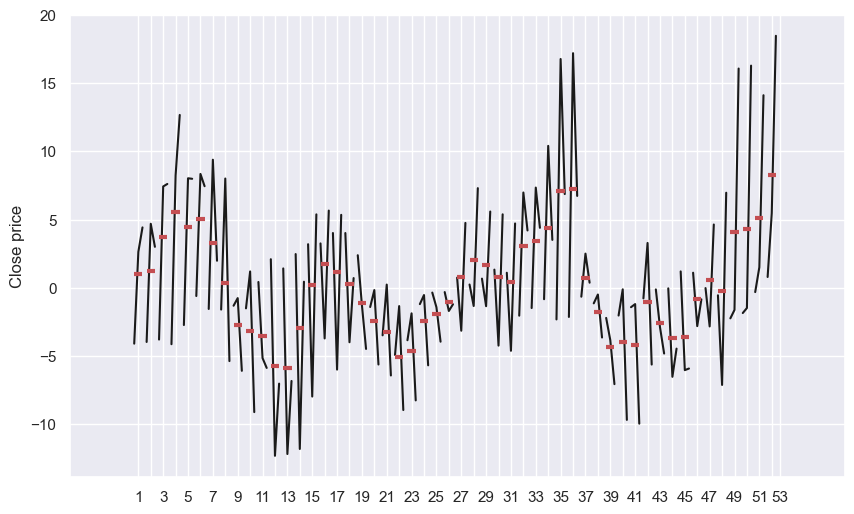

In [ ]:
# Seasonal plot

_, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.tsa.seasonal_plot(
    groupby_week_object, xticklabels=xticklabels, ylabel="Close price", ax=ax
)

# Prevent some xticks from plotting
every_nth_tick = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth_tick != 0:
        label.set_visible(False)

## Graphe de saisonnalité par superposition de séries

In [ ]:
# Copy dataframe for seasonal plot
df_detrend_seasonality = df_detrend.copy()

# Adapt index for function
df_detrend_seasonality.index = df_detrend_seasonality.index.to_period("D")

# Define dummies
df_detrend_seasonality["weekofyear"] = df_detrend_seasonality.index.week
df_detrend_seasonality["dayofyear"] = df_detrend_seasonality.index.dayofyear
df_detrend_seasonality["year"] = df_detrend_seasonality.index.year

c:\Users\jules\Desktop\Cours\DataScience\stock-analysis\src\functions\seasonality.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (year/weekofyear)'}, xlabel='weekofyear', ylabel='Close'>

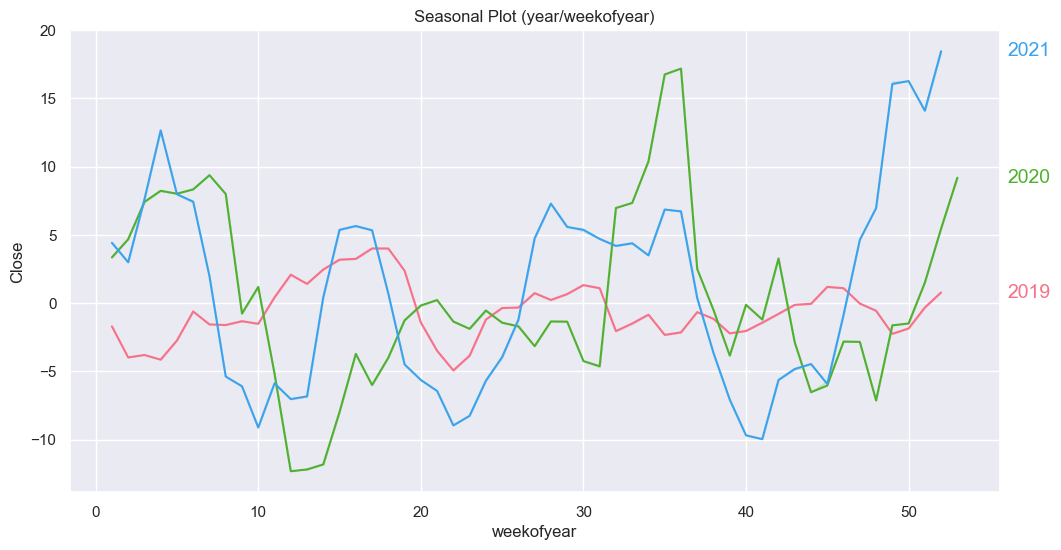

In [ ]:
# Seasonal plot
_, ax = plt.subplots(figsize=(12, 6))
SeasonalPlotter.seasonal_plot(
    X=df_detrend_seasonality, y="Close", period="year", freq="weekofyear", ax=ax
)

c:\Users\jules\Desktop\Cours\DataScience\stock-analysis\src\functions\seasonality.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='Close'>

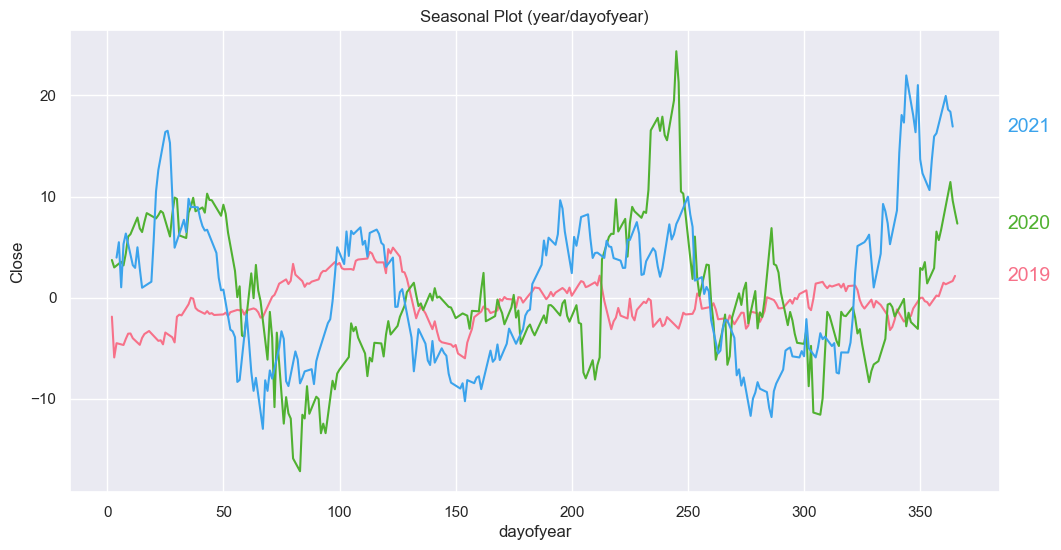

In [ ]:
# Seasonal plot
_, ax = plt.subplots(figsize=(12, 6))
SeasonalPlotter.seasonal_plot(
    X=df_detrend_seasonality, y="Close", period="year", freq="dayofyear", ax=ax
)

## Périodogramme

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

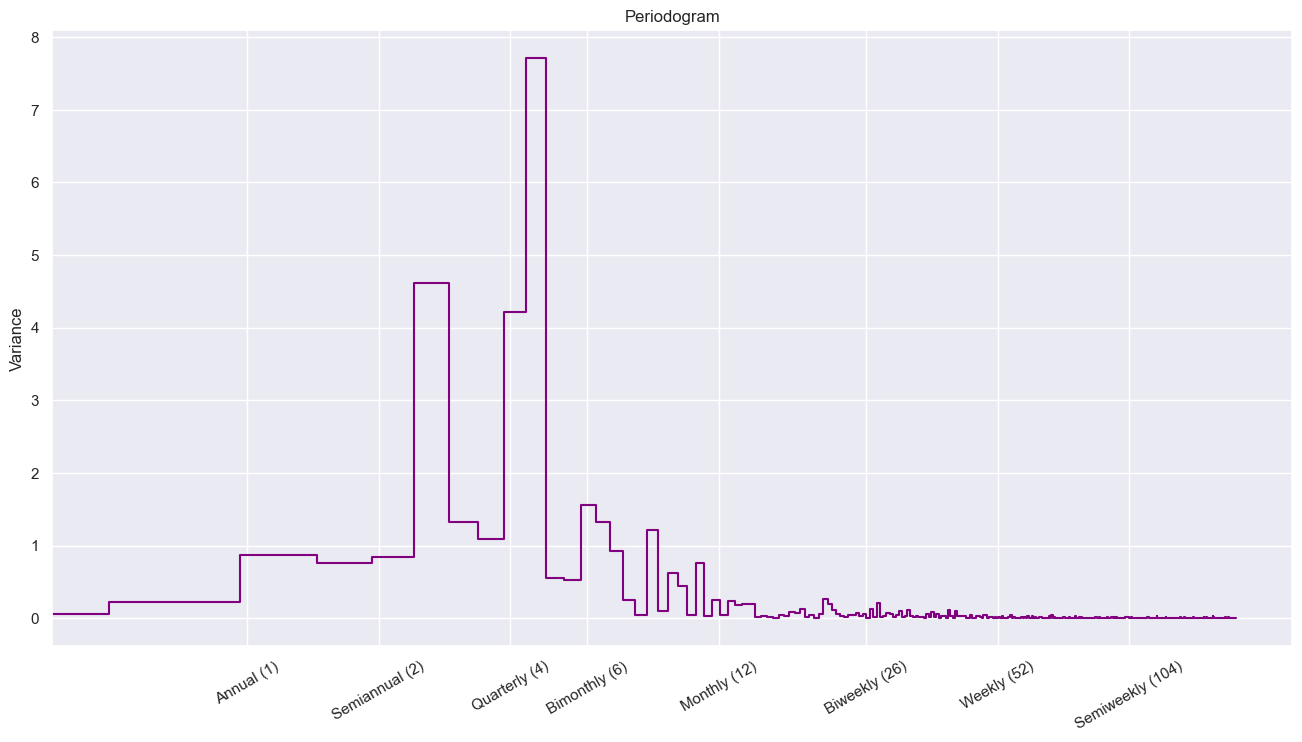

In [ ]:
SeasonalPlotter.plot_periodogram(time_series=df_detrend["Close"], detrend=False)

Le périodogramme met en évidence des fréquences importantes semi-annuelle et trimestrielle.  
Ces fréquences se constatent sur les graphes de saisonnalité, avec des cycles trimestrielles. 

## Différenciation saisonnière

In [ ]:
# Define the seasonal frequencies
quarterly_freq = 90
semiannual_freq = 180

In [ ]:
# Differencing on quaterly frequency
df_detrend["close_without_season"] = df_detrend["Close"] - df_detrend["Close"].shift(
    quarterly_freq
)

# Differencing on semiannual frequency
df_detrend["close_without_season"] = df_detrend["close_without_season"] - df_detrend[
    "Close"
].shift(semiannual_freq)

In [ ]:
df_detrend["close_without_season"].isna().sum()

180

Nous avons désormais un jeu de données sans saisonnalité avec 180 jours de données manquantes.  
Cet effet est dû à la différenciation semi annuelle. 

<Axes: title={'center': 'Close price detrended'}, xlabel='Date'>

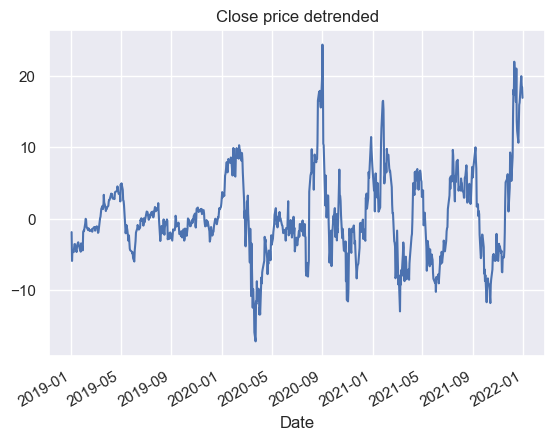

In [ ]:
df_detrend["Close"].plot(title="Close price detrended")

<Axes: title={'center': 'Close price detrended and differenced for seasonality'}, xlabel='Date'>

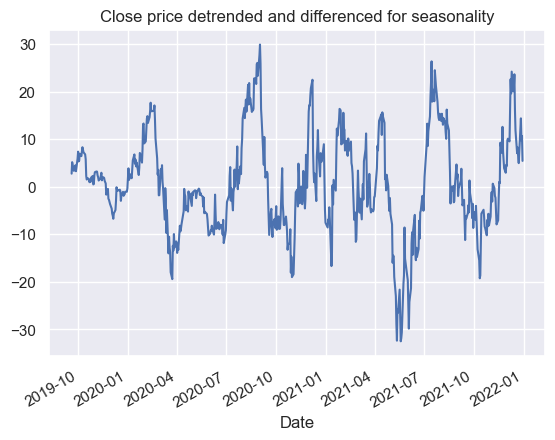

In [ ]:
df_detrend["close_without_season"].plot(
    title="Close price detrended and differenced for seasonality"
)

In [ ]:
df_detrend["close_without_season"].to_csv(
    "data/processed_data/season_treated_data/quaterly_semiannual_differencing/AAPL.csv"
)

## Modèle ARIMA

Cette partie est consacrée à la détermination des paramètres du modèle prédictif ARIMA de paramètres $p, d, q$ qui désignent respectivement :
- L'ordre autorégressif
- L'ordre de différenciation pour atteindre la stationnarité
- L'ordre de moyenne mobile 

In [ ]:
time_series = df_detrend["close_without_season"]
time_series = time_series[~time_series.isna()]
time_series

Date
2019-09-19     2.746602
2019-09-20     5.162185
2019-09-23     3.355712
2019-09-24     3.423930
2019-09-25     3.872582
                ...    
2021-12-23     4.962022
2021-12-27    14.379935
2021-12-28     9.723572
2021-12-29    10.662810
2021-12-30     5.430709
Name: close_without_season, Length: 576, dtype: float64

### Détermination de l'ordre de différenciation

In [ ]:
stationary_time_series, num_diffs, adfuller_pvalue = check_stationarity_and_difference(
    time_series
)

pvalue for adfuller test on differencing order 1 is 0.0


Une différenciation suffit à obtenir une série stationnaire.  
Nous choisissons donc le paramètres $d$ valant 1 pour le modèle ARIMA.

### Détermination de l'ordre autorégressif

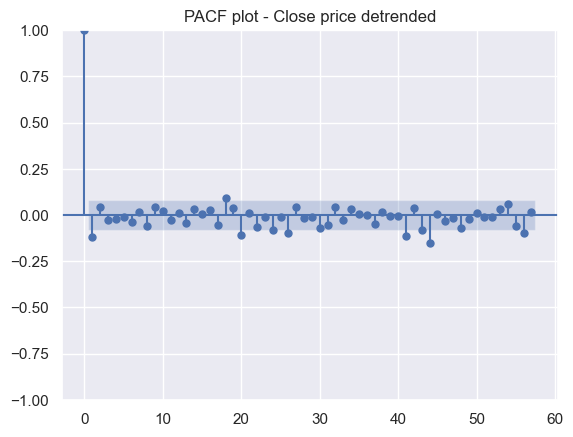

In [ ]:
lag = (
    len(stationary_time_series) // 10
)  # Display lags from 0 to 1/10 of time series length

_ = plot_pacf(
    stationary_time_series, lags=lag, title="PACF plot - Close price detrended"
)

Le graphique des autocorrélations partielles passe à 0, au seuil de confiance de 95%, au deuxième retard.  
Nous choisissons donc le paramètre $p$ valant 2 pour le modèle ARIMA.

### Détermination de l'ordre de moyenne mobile

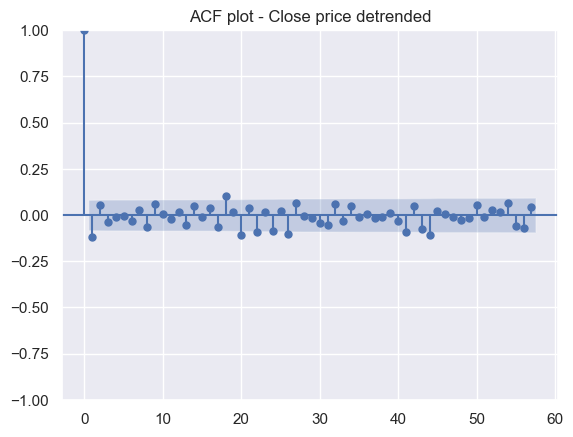

In [ ]:
lag = (
    len(stationary_time_series) // 10
)  # Display lags from 0 to 1/10 of time series length

_ = plot_acf(stationary_time_series, lags=lag, title="ACF plot - Close price detrended")

Le graphique des autocorrélations passe à 0, au seuil de confiance de 95%, au deuxième retard.  
Nous choisissons donc le paramètre $q$ valant 2 pour le modèle ARIMA.